# Lights, Camera, Action! Challenge

Welcome to the Lights, Camera, Action Challenge! In this thrilling competition, you will dive into the world of movies and TV shows, predicting the IMDB score classes like a seasoned film critic. The IMDB score is a well-established metric in the film industry, serving as a barometer for a title's quality. Ready for your close-up? Let's roll!

For this challenge, you will have 4 csv files: train_titles.csv, train_credits.csv, test_titles.csv, and test_credits.csv.

The train_credits.csv and test_credits.csv files are your supporting cast, providing extra information about the actors and directors of each title. Although adding the titles credits information can boost your model performance, it is not required to use the credits datasets.

Your only objective is: Predicting the IMDB score for the test titles. Please note that your model should predict the IMDB score, and then transform this score into the target column using the get_imdb_score_class function provided. Your performance will be judged using the F1 macro score with the target column.

## 1. Exploring the titles database

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("train_titles.csv")
pd.set_option("display.max_columns", df.shape[1])
df.head()

,train_idx,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,streaming,imdb_votes,imdb_score,target
0,0,tm164331,The Marquis,MOVIE,"Thomas Gardesse, a traveling alarm systems sal...",2011,G,88,"['comedy', 'european', 'crime', 'drama']",['FR'],NaN,amazon,816,4.9,3
1,1,ts89550,Fire Force,SHOW,"Year 198 of the Solar Era in Tokyo, special fi...",2019,TV-14,24,"['scifi', 'comedy', 'action', 'fantasy', 'anim...",['JP'],2.0,hulu,8621,7.6,6
2,2,tm79689,30 Days of Night,MOVIE,This is the story of an isolated Alaskan town ...,2007,R,113,"['horror', 'thriller', 'action']","['NZ', 'US']",NaN,hulu,181869,6.6,5
3,3,tm372366,306 Hollywood,MOVIE,When two siblings undertake an archaeological ...,2018,NaN,94,['documentation'],['US'],NaN,amazon,307,6.8,5
4,4,tm60248,Child's Play,MOVIE,A single mother gives her son a beloved doll f...,1988,R,87,"['horror', 'thriller', 'fantasy']",['US'],NaN,hbo,108017,6.6,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16545 entries, 0 to 16544
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   train_idx             16545 non-null  int64  
 1   id                    16545 non-null  object 
 2   title                 16545 non-null  object 
 3   type                  16545 non-null  object 
 4   description           16512 non-null  object 
 5   release_year          16545 non-null  int64  
 6   age_certification     8646 non-null   object 
 7   runtime               16545 non-null  int64  
 8   genres                16545 non-null  object 
 9   production_countries  16545 non-null  object 
 10  seasons               4422 non-null   float64
 11  streaming             16545 non-null  object 
 12  imdb_votes            16545 non-null  int64  
 13  imdb_score            16545 non-null  float64
 14  target                16545 non-null  int64  
dtypes: float64(2), int6

In [4]:
df.duplicated().value_counts()

False    16545
dtype: int64

In [5]:
df.isna().sum()

train_idx                   0
id                          0
title                       0
type                        0
description                33
release_year                0
age_certification        7899
runtime                     0
genres                      0
production_countries        0
seasons                 12123
streaming                   0
imdb_votes                  0
imdb_score                  0
target                      0
dtype: int64

We will discard the following features for the modelling: title, description. So we do not need to worry about the NaN in description.

Next we explore and transform the relevant features one at a time.

### Seasons

In [6]:
movies = df[df["type"] == "MOVIE"]
print(movies["seasons"].unique())
shows = df[df["type"] == "SHOW"]
print(shows["seasons"].unique())

[nan]
[ 2.  8.  1.  5.  4. 17.  3.  9.  6. 12. 36. 31. 10. 26. 11. 20.  7. 53.
 16. 21. 19. 34. 32. 13. 27. 15. 14. 50. 22. 33. 24. 25. 18. 23. 30. 38.
 45. 29. 35.]


After checking that only "MOVIE" types have NaN value for seasons, we will fill these NANs with zeros.

In [7]:
df["seasons"].fillna(0, inplace=True)
df["seasons"].value_counts()

0.0     12123
1.0      2165
2.0       783
3.0       486
4.0       264
5.0       196
6.0       151
7.0        98
8.0        57
9.0        33
11.0       31
10.0       27
12.0       19
13.0       12
15.0       11
16.0       11
14.0        9
21.0        8
24.0        7
17.0        5
20.0        5
33.0        5
19.0        4
31.0        4
18.0        4
22.0        3
30.0        3
26.0        3
34.0        3
25.0        3
29.0        2
36.0        2
45.0        1
38.0        1
53.0        1
23.0        1
50.0        1
27.0        1
32.0        1
35.0        1
Name: seasons, dtype: int64

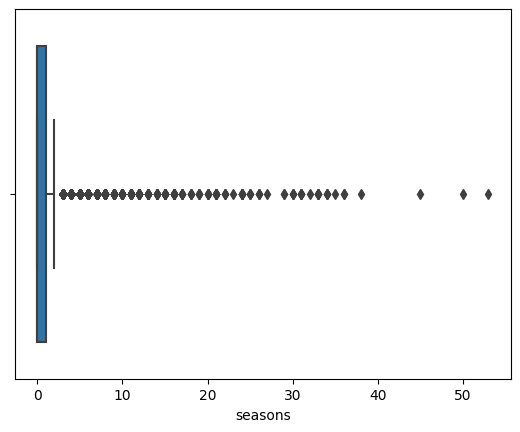

In [8]:
sns.boxplot(x=df["seasons"]);

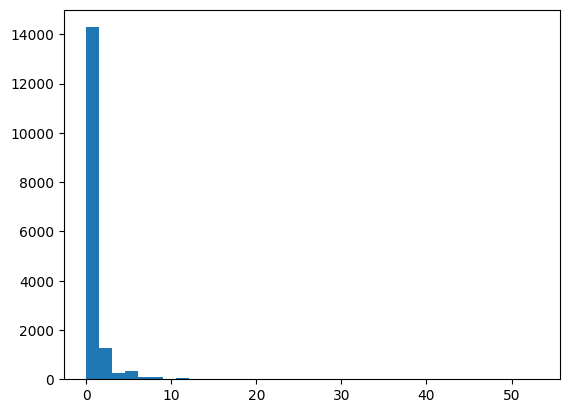

In [9]:
plt.hist(df["seasons"], bins=35)
plt.show;

We will dummify this discrete feature into three groups (0, 1, 2+ seasons).

In [10]:
seasons = ["0seasons", "1seasons", "2+seasons"]

def fillSeasons (input):
    if i == 0:
        if input == 0:
            return 1
        else:
            return 0
    if i == 1:
        if input == 1:
            return 1
        else:
            return 0
    if i == 2:
        if input >= 2:
            return 1
        else:
            return 0
    
i = 0
while i < len(seasons):
    df[seasons[i]] = df["seasons"].apply(fillSeasons)
    i += 1

### Runtime

In [11]:
df["runtime"].describe()

count    16545.000000
mean        81.471804
std         35.837430
min          0.000000
25%         53.000000
50%         88.000000
75%        104.000000
max        328.000000
Name: runtime, dtype: float64

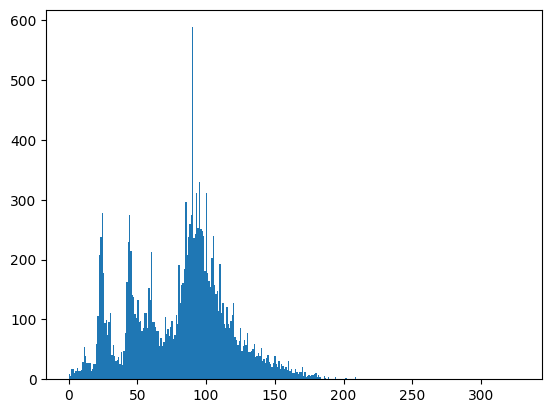

In [12]:
plt.hist(df["runtime"], bins=329)
plt.show;

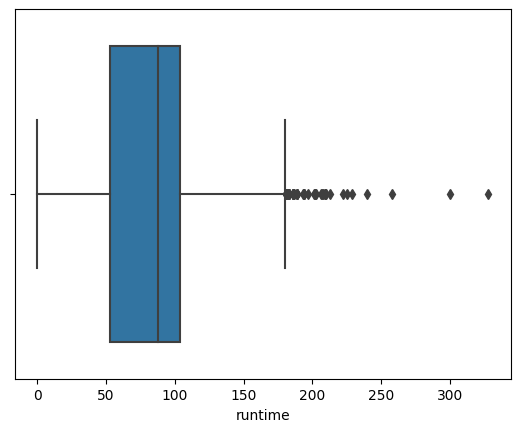

In [13]:
sns.boxplot(x=df["runtime"]);

There are a few lines with runtime = 0 or very close, however this implies few cases and could be theoretically possible (runtimes of a few seconds, maybe in children animation titles), so we will not fix anything here.

### Genres

In [14]:
df["genres"].unique()

array(["['comedy', 'european', 'crime', 'drama']",
       "['scifi', 'comedy', 'action', 'fantasy', 'animation', 'drama']",
       "['horror', 'thriller', 'action']", ...,
       "['fantasy', 'scifi', 'action']", "['drama', 'music', 'action']",
       "['romance', 'crime', 'drama', 'thriller']"], dtype=object)

In [15]:
import re

genres = []

for x in df["genres"]:
    text = re.sub(r"[\'\[\],]","", x)
    words = text.split()
    for x in words:
        genres.append(x)
genres = list(dict.fromkeys(genres))    

print(genres)
print(len(genres))

['comedy', 'european', 'crime', 'drama', 'scifi', 'action', 'fantasy', 'animation', 'horror', 'thriller', 'documentation', 'romance', 'family', 'reality', 'history', 'music', 'western', 'sport', 'war']
19


Few titles are assigned to one single genre. After splitting every list of genres in the dataset and checking there are only 19 different genres, we will dummify this feature with a custom function, allowing every title to check in as many genres as it has.

In [16]:
def fillGenres (input):
    text = re.sub(r"[\'\[\],]","", input)
    words = text.split()
    match = 0
    for word in words:
        if word == genres[i]:
            match += 1
    if match > 0:
        return 1
    else:
        return 0

i = 0
while i < len(genres):
    df[genres[i]] = df["genres"].apply(fillGenres)
    i += 1

pd.set_option("display.max_columns", df.shape[1])
df.head()

,train_idx,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,streaming,imdb_votes,imdb_score,target,0seasons,1seasons,2+seasons,comedy,european,crime,drama,scifi,action,fantasy,animation,horror,thriller,documentation,romance,family,reality,history,music,western,sport,war
0,0,tm164331,The Marquis,MOVIE,"Thomas Gardesse, a traveling alarm systems sal...",2011,G,88,"['comedy', 'european', 'crime', 'drama']",['FR'],0.0,amazon,816,4.9,3,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,ts89550,Fire Force,SHOW,"Year 198 of the Solar Era in Tokyo, special fi...",2019,TV-14,24,"['scifi', 'comedy', 'action', 'fantasy', 'anim...",['JP'],2.0,hulu,8621,7.6,6,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2,2,tm79689,30 Days of Night,MOVIE,This is the story of an isolated Alaskan town ...,2007,R,113,"['horror', 'thriller', 'action']","['NZ', 'US']",0.0,hulu,181869,6.6,5,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0
3,3,tm372366,306 Hollywood,MOVIE,When two siblings undertake an archaeological ...,2018,NaN,94,['documentation'],['US'],0.0,amazon,307,6.8,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,4,tm60248,Child's Play,MOVIE,A single mother gives her son a beloved doll f...,1988,R,87,"['horror', 'thriller', 'fantasy']",['US'],0.0,hbo,108017,6.6,5,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0


### Production countries

In [17]:
producers = []

for x in df["production_countries"]:
    text = re.sub(r"[\'\[\],]","", x)
    words = text.split()
    for x in words:
        producers.append(x)
producers = list(dict.fromkeys(producers))    

print(producers)
print(len(producers))

['FR', 'JP', 'NZ', 'US', 'BR', 'CA', 'DE', 'IN', 'TR', 'PH', 'GB', 'MY', 'AU', 'KR', 'DK', 'BE', 'KE', 'IT', 'ID', 'YU', 'CN', 'TW', 'CD', 'NP', 'ES', 'SA', 'AE', 'CL', 'MX', 'CI', 'UG', 'HK', 'NL', 'UY', 'NG', 'UA', 'IS', 'SG', 'TH', 'LB', 'EG', 'JO', 'AT', 'CO', 'ZA', 'SE', 'CH', 'FI', 'AR', 'AF', 'GR', 'NO', 'DO', 'BD', 'RU', 'BG', 'PL', 'CZ', 'PR', 'MN', 'SK', 'LU', 'LV', 'PT', 'SU', 'IE', 'VN', 'IQ', 'RO', 'BS', 'KH', 'JM', 'PE', 'IL', 'SN', 'PS', 'QA', 'MA', 'XC', 'HU', 'SI', 'CU', 'CR', 'GT', 'MW', 'GH', 'TT', 'BY', 'GE', 'RW', 'IR', 'RS', 'EE', 'ZW', 'KW', 'TC', 'VE', 'KI', 'MC', 'GQ', 'TN', 'VU', 'FM', 'SB', 'CM', 'DZ', 'AN', 'HN', 'LT', 'SZ', 'SY', 'PK', 'KZ', 'BA', 'HR', 'PA', 'LI', 'EC', 'AL', 'SV', 'PY', 'TZ', 'BT', 'CS', 'BO', 'CY', 'FJ', 'PF', 'MT', 'LK', 'XK', 'BF', 'ET', 'IO', 'NC', 'GL', 'MK', 'MU']
138


In [18]:
df["production_countries"].value_counts().head(20)

['US']          8593
['IN']          1320
['GB']           899
['JP']           558
['CA']           431
['KR']           279
['FR']           219
['ES']           195
['AU']           183
['GB', 'US']     168
['MX']           157
['CA', 'US']     148
['IT']           139
['NG']           129
['DE']           119
['BR']           115
['CN']           103
['US', 'CA']      99
['US', 'GB']      93
['PH']            75
Name: production_countries, dtype: int64

This feature is quite similar to genres, however there are 138 different producing countries in the dataset. We will dummify the feature, after reducing the number of different producing countries to the few most present, then a group for other European countries, and finally a last group with the remaining countries.

In [19]:
producersGrouped = ["US", "IN", "GB", "JP", "CA", "KR", "EUR", "OTHER"]
producersEurope = ["AL", "AT", "BA", "BE", "BG", "CH", "CY", "CZ", "DE", "DK", "EE", "ES", "FI", "FR", "GR", "HR",\
                   "HU", "IE", "IS", "IT", "LT", "LU", "LV", "ME", "MK", "MT", "NL", "NO", "PL", "PT", "RO", "RS",\
                   "SE", "SI", "SK", "YU"]

def fillProducers (input):
    text = re.sub(r"[\'\[\],]","", input)
    words = text.split()
    match = 0
    if i < 6:
        for word in words:
            if word == producersGrouped[i]:
                match += 1
        if match > 0:
            return 1
        else:
            return 0
    if i == 6:
        for word in words:
            if word in producersEurope:
                match += 1
        if match > 0:
            return 1
        else:
            return 0    
    if i == 7:
        for word in words:
            if word in producersGrouped or word in producersEurope:
                match += 1
        if len(words) > match:
            return 1
        else:
            return 0                

i = 0
while i < len(producersGrouped):
    df[producersGrouped[i]] = df["production_countries"].apply(fillProducers)
    i += 1

pd.set_option("display.max_columns", df.shape[1])
df.head()

,train_idx,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,streaming,imdb_votes,imdb_score,target,0seasons,1seasons,2+seasons,comedy,european,crime,drama,scifi,action,fantasy,animation,horror,thriller,documentation,romance,family,reality,history,music,western,sport,war,US,IN,GB,JP,CA,KR,EUR,OTHER
0,0,tm164331,The Marquis,MOVIE,"Thomas Gardesse, a traveling alarm systems sal...",2011,G,88,"['comedy', 'european', 'crime', 'drama']",['FR'],0.0,amazon,816,4.9,3,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,ts89550,Fire Force,SHOW,"Year 198 of the Solar Era in Tokyo, special fi...",2019,TV-14,24,"['scifi', 'comedy', 'action', 'fantasy', 'anim...",['JP'],2.0,hulu,8621,7.6,6,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,tm79689,30 Days of Night,MOVIE,This is the story of an isolated Alaskan town ...,2007,R,113,"['horror', 'thriller', 'action']","['NZ', 'US']",0.0,hulu,181869,6.6,5,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,3,tm372366,306 Hollywood,MOVIE,When two siblings undertake an archaeological ...,2018,NaN,94,['documentation'],['US'],0.0,amazon,307,6.8,5,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,4,tm60248,Child's Play,MOVIE,A single mother gives her son a beloved doll f...,1988,R,87,"['horror', 'thriller', 'fantasy']",['US'],0.0,hbo,108017,6.6,5,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Type

In [20]:
types = df["type"].unique()
print(types)

['MOVIE' 'SHOW']


There are only two types of films, so we will just dummify this feature.

In [21]:
df["type"].value_counts()

MOVIE    12123
SHOW      4422
Name: type, dtype: int64

In [22]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[["type"]])
df[ohe.categories_[0]] = transformed.toarray()
df["type"].value_counts()

MOVIE    12123
SHOW      4422
Name: type, dtype: int64

### Streaming

In [23]:
streaming = df["streaming"].unique()
print(streaming)

['amazon' 'hulu' 'hbo' 'netflix' 'disney']


Same as begfore, we dummify the streaming feature as there are only five different values in the dataset.

In [24]:
df["streaming"].value_counts()

amazon     7378
netflix    4282
hbo        2045
hulu       1827
disney     1013
Name: streaming, dtype: int64

In [25]:
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[["streaming"]])
df[ohe.categories_[0]] = transformed.toarray()
df[streaming].value_counts()

amazon  hulu  hbo  netflix  disney
1.0     0.0   0.0  0.0      0.0       7378
0.0     0.0   0.0  1.0      0.0       4282
              1.0  0.0      0.0       2045
        1.0   0.0  0.0      0.0       1827
        0.0   0.0  0.0      1.0       1013
dtype: int64

### Release year

In [26]:
df["release_year"].describe()

count    16545.000000
mean      2008.226473
std         20.758918
min       1912.000000
25%       2008.000000
50%       2017.000000
75%       2020.000000
max       2023.000000
Name: release_year, dtype: float64

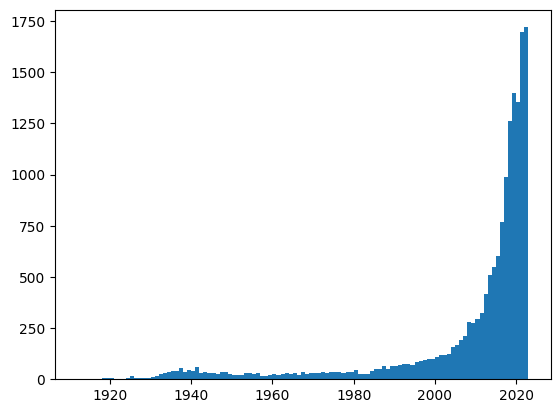

In [27]:
plt.hist(df["release_year"], bins=111)
plt.show;

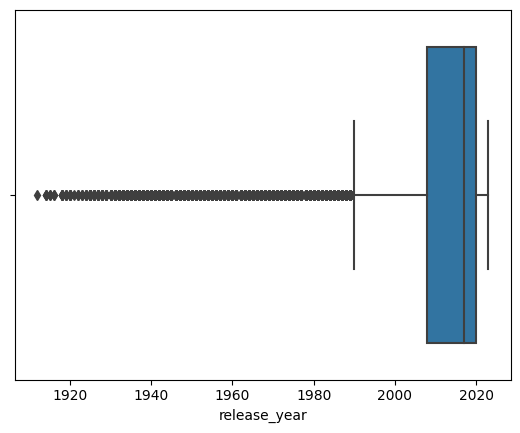

In [28]:
sns.boxplot(x=df["release_year"]);

As we did with seasons, we will dummify this discrete features into four groups close to its quartiles.

In [29]:
periods = ["2008", "2017", "2020", "2023"]

def fillPeriods (input):
    if i == 0:
        if input <= 2008:
            return 1
        else:
            return 0
    if i == 1:
        if input > 2008 and input <= 2017:
            return 1
        else:
            return 0
    if i == 2:
        if input > 2017 and input <= 2020:
            return 1
        else:
            return 0
    if i == 3:
        if input > 2020:
            return 1
        else:
            return 0
    
i = 0
while i < len(periods):
    df[periods[i]] = df["release_year"].apply(fillPeriods)
    i += 1

### IMDB votes

In [30]:
df["imdb_votes"].describe()

count    1.654500e+04
mean     2.545551e+04
std      1.059056e+05
min      5.000000e+00
25%      2.300000e+02
50%      1.306000e+03
75%      8.061000e+03
max      2.706106e+06
Name: imdb_votes, dtype: float64

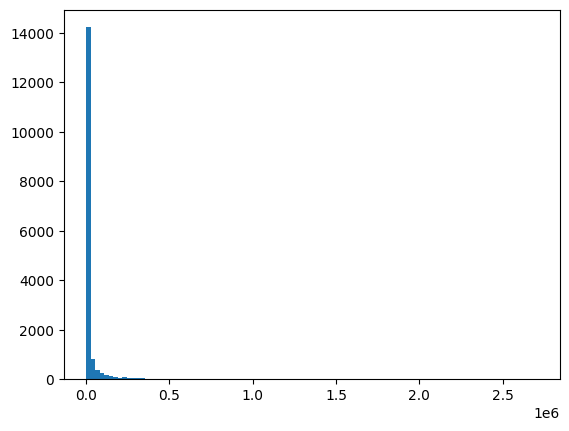

In [31]:
plt.hist(df["imdb_votes"], bins=100)
plt.show;

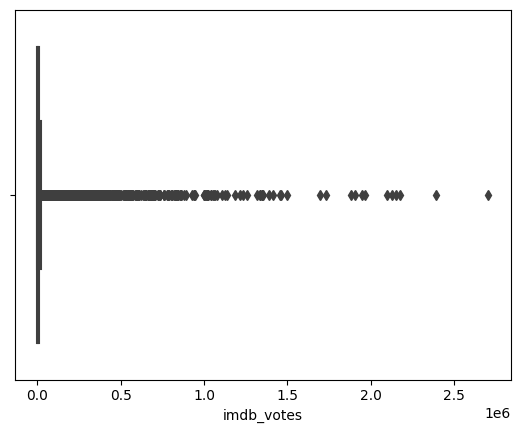

In [32]:
sns.boxplot(x=df["imdb_votes"]);

Another skewed feature here, with the median barely above 1k votes while the maximum value goes close to 3M. Although there are no "half votes", we will consider this feature as continuous.

### Age certification

In [33]:
df["age_certification"].value_counts()

R           2069
TV-MA       1377
PG-13       1284
PG          1122
TV-14       1076
G            532
TV-PG        510
TV-Y7        243
TV-G         207
TV-Y         190
NC-17         26
TV-Y7-FV      10
Name: age_certification, dtype: int64

In [34]:
age = df.groupby("age_certification")
print(age["imdb_score"].describe())

                    count      mean       std  min    25%   50%   75%  max
age_certification                                                         
G                   532.0  6.242293  1.167803  1.4  5.500  6.30  7.10  8.8
NC-17                26.0  6.057692  1.296819  3.1  5.425  6.05  7.00  8.4
PG                 1122.0  6.237968  1.175282  1.3  5.500  6.30  7.10  9.3
PG-13              1284.0  6.243224  1.147919  1.9  5.500  6.40  7.10  9.0
R                  2069.0  6.060512  1.212205  2.1  5.400  6.20  6.90  9.4
TV-14              1076.0  7.101208  1.121041  1.9  6.600  7.30  7.80  9.2
TV-G                207.0  6.745894  1.047823  3.7  6.200  6.80  7.50  9.1
TV-MA              1377.0  7.199710  0.987855  1.5  6.600  7.30  7.90  9.5
TV-PG               510.0  7.181176  1.097433  2.8  6.700  7.40  8.00  9.6
TV-Y                190.0  6.607368  1.214571  1.9  5.900  6.65  7.40  9.5
TV-Y7               243.0  6.840741  1.094929  3.2  6.200  7.00  7.65  9.4
TV-Y7-FV             10.0

These categories are rather meaningless, especially for non-US residents. However there is value in them, as they clearly "TV" tagged ones get higher IMDB scores than the others. So we will dummify the feature after grouping the categories.

In [35]:
ageTV = ["TV-14", "TV-G", "TV-MA", "TV-PG", "TV-Y", "TV-Y7", "TV-Y7-FV"]
ageOther = ["G", "NC-17", "PG", "PG-13", "R"]
ageGroups = ["ageTV", "ageOther", "ageNone"]

def fillAges (input):
    if i == 0:
        if input in ageTV:
            return 1
        else:
            return 0
    if i == 1:
        if input in ageOther:
            return 1
        else:
            return 0
    if i == 2:
        if input in ageTV or input in ageOther:
            return 0
        else:
            return 1
    
i = 0
while i < len(ageGroups):
    df[ageGroups[i]] = df["age_certification"].apply(fillAges)
    i += 1

### IMDB score

In [36]:
df["imdb_score"].describe()

count    16545.000000
mean         6.342883
std          1.288036
min          1.100000
25%          5.600000
50%          6.500000
75%          7.300000
max         10.000000
Name: imdb_score, dtype: float64

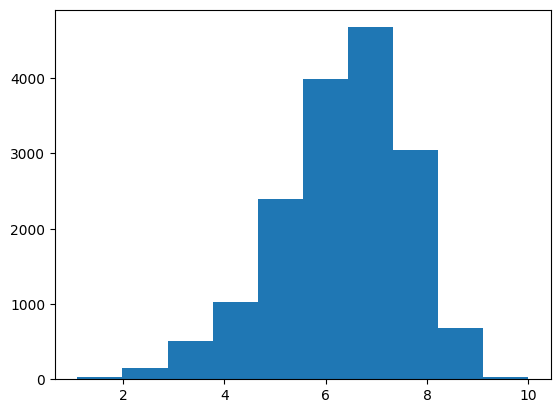

In [37]:
plt.hist(df["imdb_score"], bins=10)
plt.show;

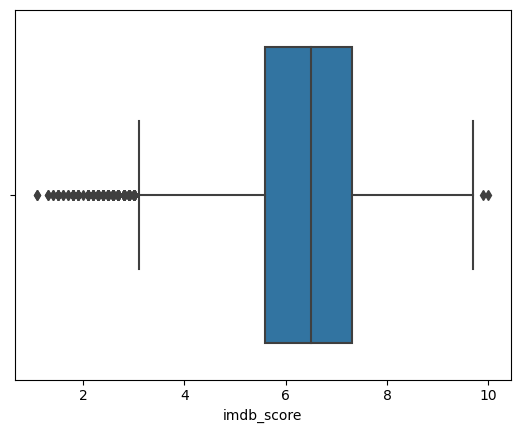

In [38]:
sns.boxplot(x=df["imdb_score"]);

### Target

In [39]:
df["target"].describe()

count    16545.000000
mean         4.895678
std          1.321549
min          0.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          8.000000
Name: target, dtype: float64

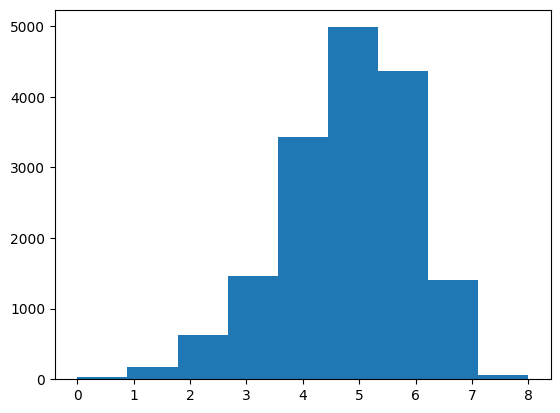

In [40]:
plt.hist(df["target"], bins=9)
plt.show;

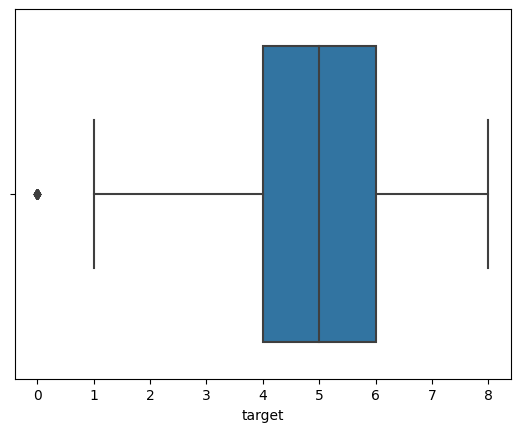

In [41]:
sns.boxplot(x=df["target"]);

## 2. Bringing features fomr the Credits dataset

In [42]:
credits = pd.read_csv("train_credits.csv")
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258488 entries, 0 to 258487
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  258488 non-null  int64 
 1   person_id   258488 non-null  int64 
 2   id          258488 non-null  object
 3   name        258488 non-null  object
 4   character   233035 non-null  object
 5   role        258488 non-null  object
dtypes: int64(2), object(4)
memory usage: 11.8+ MB


In [43]:
credits.duplicated().value_counts()

False    258488
dtype: int64

In [44]:
credits.head()

,Unnamed: 0,person_id,id,name,character,role
0,0,25020,tm87233,James Stewart,George Bailey,ACTOR
1,1,26190,tm87233,Donna Reed,Mary Hatch,ACTOR
2,2,25653,tm87233,Lionel Barrymore,Mr. Potter,ACTOR
3,3,13301,tm87233,Thomas Mitchell,Uncle Billy,ACTOR
4,4,34171,tm87233,Henry Travers,Clarence,ACTOR


In [45]:
credits["person_id"] = credits["person_id"].astype(str)

Our goal is to merge the data on the director of every movie into the main dataset, then find the average IMDB score of every director and feed this new feature into the model too.

In [46]:
credits["role"].value_counts()

ACTOR       244812
DIRECTOR     13676
Name: role, dtype: int64

In [47]:
credits["name"][credits["role"] == "DIRECTOR"].value_counts()

Joseph Kane                    31
Sam Newfield                   29
Jay Chapman                    25
Jay Karas                      22
Ryan Polito                    19
                               ..
Brando Keoni Bowthorpe          1
Aurélien Vernhes-Lermusiaux     1
Marco Castillo                  1
Barbara Topsøe-Rothenborg       1
Rahul V. Chittella              1
Name: name, Length: 9326, dtype: int64

In [48]:
directors = credits[["id", "person_id", "name"]][credits["role"] == "DIRECTOR"]
directors.head()

,id,person_id,name
115,tm87233,20177,Frank Capra
138,tm19248,28732,Clyde Bruckman
139,tm19248,21174,Buster Keaton
170,tm82253,13717,William Wyler
191,tm38206,155568,Thornton Freeland


In [49]:
directors.shape

(13676, 3)

In [50]:
directors["id"].value_counts()

tm160587     31
tm317518     18
tm1251373    12
tm145050     12
tm74391      12
             ..
tm289943      1
tm373283      1
tm446877      1
tm1264268     1
tm1306464     1
Name: id, Length: 11994, dtype: int64

In [51]:
credits[credits["id"] == "tm74391"].head(30)

,Unnamed: 0,person_id,id,name,character,role
103202,103202,23433,tm74391,Deems Taylor,Narrator - Narrative Introductions,ACTOR
103203,103203,5910,tm74391,Walt Disney,Mickey Mouse (segment 'The Sorcerer's Apprenti...,ACTOR
103204,103204,23436,tm74391,Julietta Novis,Soloist (segment 'Ave Maria') (singing voice),ACTOR
103205,103205,23434,tm74391,Leopold Stokowski,Himself - Conductor of The Philadelphia Orchestra,ACTOR
103206,103206,23441,tm74391,Paul Satterfield,NaN,DIRECTOR
103207,103207,23442,tm74391,Hamilton Luske,NaN,DIRECTOR
103208,103208,23443,tm74391,Jim Handley,NaN,DIRECTOR
103209,103209,6164,tm74391,Ford Beebe,NaN,DIRECTOR
103210,103210,23444,tm74391,T. Hee,NaN,DIRECTOR
103211,103211,23446,tm74391,Wilfred Jackson,NaN,DIRECTOR


While one would expect the films to have one director only (or at least for movies, maybe not for shows), this is not the case. So when there is more than one director, as we cannot manually choose which one is the "good" one, we'll rather tag these films as having unknown director.

In [52]:
directors.drop_duplicates(subset="id", keep=False, inplace=True, ignore_index=True)
directors.shape

(10690, 3)

In [53]:
df = pd.merge(df, directors, how="left", on="id")
df.shape

(16545, 61)

In [54]:
df["person_id"].fillna("unknown", inplace=True)
df["person_id"].value_counts()

unknown    5855
151608       31
124433       29
56729        21
159658       18
           ... 
275848        1
240070        1
52236         1
357930        1
154099        1
Name: person_id, Length: 7576, dtype: int64

With every film in the main dataset now having either one single director or an unknown one, we can now find their average IMDB scores.

In [55]:
def getScore (input):
    return df["imdb_score"][df["person_id"] == input].mean() 

df["director_score"] = df["person_id"].apply(getScore)
df["director_score"].describe()

count    16545.000000
mean         6.342883
std          0.985906
min          1.100000
25%          5.900000
50%          6.750179
75%          6.750179
max          9.600000
Name: director_score, dtype: float64

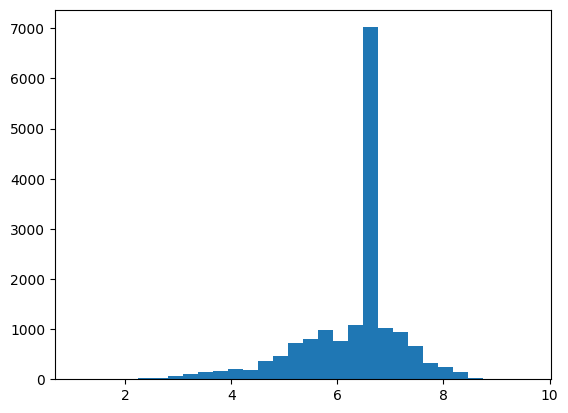

In [56]:
plt.hist(df["director_score"], bins = 30)
plt.show;

We will also prepare a dictionary with every director score that we'll later check to fill this information in the test dataset.

In [57]:
directorScores = pd.Series(df["director_score"].values, index=df["person_id"]).to_dict()
print(len(directorScores))

7576


## 3. Transformations

With most features being categorical or discrete, which have been dummified before, the only transformation left it to bring the ranges of the numerical ones closer. As they all have outlier values, this will be done with the Robust Scaler transformer.

In [58]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
df[["runtimeSC", "imdb_votesSC", "director_scoreSC"]] = scaler.fit_transform(df[["runtime", "imdb_votes", "director_score"]])
df[["runtimeSC", "imdb_votesSC", "director_scoreSC"]].describe()

,runtimeSC,imdb_votesSC,director_scoreSC
count,16545.000000,16545.000000,16545.000000
mean,-0.128004,3.083835,-0.479071
std,0.702695,13.523894,1.159645
min,-1.725490,-0.166135,-6.645868
25%,-0.686275,-0.137403,-1.000000
50%,0.000000,0.000000,0.000000
75%,0.313725,0.862597,0.000000
max,4.705882,345.396501,3.352023


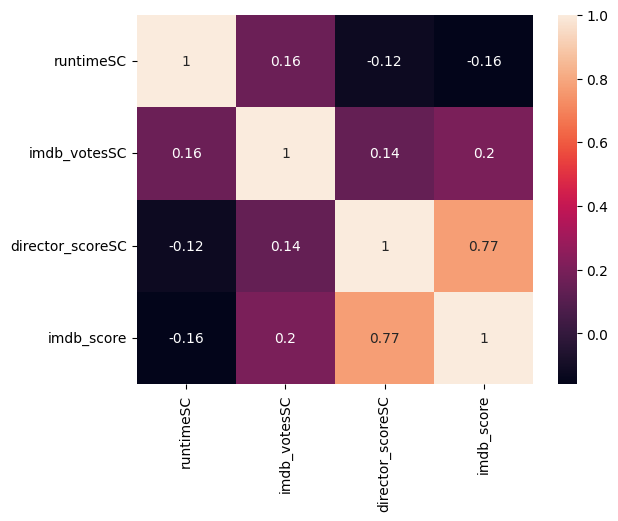

In [59]:
sns.heatmap(df[["runtimeSC", "imdb_votesSC", "director_scoreSC", "imdb_score"]].corr().round(2), annot=True);

We can also see how the average scoring of the directors is very relevant to the IMDB score of each film.

## 4. Defining the train, test and validation subsets
We will keep 10% of the lines for validation, then split the remaining ones into 80% for training and 20% for testing.

In [60]:
from sklearn.model_selection import train_test_split

X = df[[*types, *periods, "runtimeSC", *genres, *producersGrouped, *seasons, *streaming, *ageGroups, "imdb_votesSC", "director_scoreSC"]]
y = df[["imdb_score"]]

X_main, X_val, y_main, y_val = train_test_split(X, y, test_size=0.1, random_state=10)
print("Subset: (Lines, Columns)")
print("X_main: ", X_main.shape, "\ny_main: ", y_main.shape, "\nX_val: ", X_val.shape, "\ny_val: ", y_val.shape)

Subset: (Lines, Columns)
X_main:  (14890, 47) 
y_main:  (14890, 1) 
X_val:  (1655, 47) 
y_val:  (1655, 1)


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_main, y_main, test_size=0.2, random_state=10)
print("Subset: (Lines, Columns)")
print("X_train: ", X_train.shape, "\ny_train: ", y_train.shape, "\nX_test: ", X_test.shape, "\ny_test: ", y_test.shape)

Subset: (Lines, Columns)
X_train:  (11912, 47) 
y_train:  (11912, 1) 
X_test:  (2978, 47) 
y_test:  (2978, 1)


## 5. Trying and comparing regression models
### R2 and MSE

In [62]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(X_train, y_train)
print("Linear Regression \n r2: ", LR.score(X_test, y_test).round(3), "\n Coeficients: ", LR.coef_.round(3), "\n")

from sklearn.tree import DecisionTreeRegressor
RT = DecisionTreeRegressor(random_state=10).fit(X_train, y_train)
print("Regression Tree \n r2: ", RT.score(X_test, y_test).round(3), "\n Depth: ", RT.get_depth(), "\n Leaves: ", RT.get_n_leaves(), "\n Feature importances: ", RT.feature_importances_.round(3), "\n")

from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor(random_state=5).fit(X_train, y_train)
print("Random Forest Regressor \n r2: ", RF.score(X_test, y_test).round(3), "\n Feature importances: ", RF.feature_importances_.round(3), "\n")

from sklearn.svm import SVR
SVMr = SVR().fit(X_train, y_train)
print("Support Vector Machines \n r2: ", SVMr.score(X_test, y_test).round(3), "\n")

from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor().fit(X_train, y_train)
print("Gradient Boosting Regressor \n r2: ", GBR.score(X_test, y_test).round(3))

Linear Regression 
 r2:  0.656 
 Coeficients:  [[-6.20315203e+11 -2.72325626e+11 -1.46559991e+09 -1.46559991e+09
  -1.46559991e+09 -1.46559991e+09  1.24000000e-01  4.40000000e-02
   7.40000000e-02  4.50000000e-02  1.83000000e-01 -1.03000000e-01
  -8.20000000e-02  5.70000000e-02  9.80000000e-02 -1.75000000e-01
  -4.80000000e-02  4.18000000e-01 -3.80000000e-02 -1.64000000e-01
  -5.51000000e-01  1.74000000e-01  6.90000000e-02  1.20000000e-01
   1.31000000e-01  7.00000000e-02 -4.90000000e-02 -1.00000000e-02
   5.60000000e-02  2.10000000e-01 -5.00000000e-03  1.22000000e-01
  -6.70000000e-02 -3.50000000e-02  2.11701881e+11 -1.36287697e+11
  -1.36287697e+11  8.00007464e+07  8.00007465e+07  8.00007466e+07
   8.00007465e+07  8.00007465e+07  7.97345584e+09  7.97345584e+09
   7.97345584e+09  9.00000000e-03  6.97000000e-01]] 

Regression Tree 
 r2:  0.469 
 Depth:  40 
 Leaves:  8424 
 Feature importances:  [0.    0.043 0.007 0.006 0.005 0.007 0.065 0.005 0.004 0.003 0.005 0.004
 0.005 0.004 0.003

In [63]:
from sklearn.metrics import r2_score, mean_squared_error

y_predict_LR = LR.predict(X_val)
print("Linear Regression \nR2: ", r2_score(y_val, y_predict_LR).round(3), "\nMSE: ", mean_squared_error(y_val, y_predict_LR).round(3), "\n")

y_predict_RT = RT.predict(X_val)
print("Regression Tree \nR2: ", r2_score(y_val, y_predict_RT).round(3), "\nMSE: ", mean_squared_error(y_val, y_predict_RT).round(3), "\n")

y_predict_RF = RF.predict(X_val)
print("Random Forest Regressor \nR2: ", r2_score(y_val, y_predict_RF).round(3), "\nMSE: ", mean_squared_error(y_val, y_predict_RF).round(3), "\n")

y_predict_SVMr = SVMr.predict(X_val)
print("Support Vector Machines \nR2: ", r2_score(y_val, y_predict_SVMr).round(3), "\nMSE: ", mean_squared_error(y_val, y_predict_SVMr).round(3), "\n")

y_predict_GBR = GBR.predict(X_val)
print("Gradient Boosting Regressor \nR2: ", r2_score(y_val, y_predict_GBR).round(3), "\nMSE: ", mean_squared_error(y_val, y_predict_GBR).round(3))

Linear Regression 
R2:  0.641 
MSE:  0.601 

Regression Tree 
R2:  0.446 
MSE:  0.927 

Random Forest Regressor 
R2:  0.693 
MSE:  0.514 

Support Vector Machines 
R2:  0.649 
MSE:  0.588 

Gradient Boosting Regressor 
R2:  0.677 
MSE:  0.54


The comparison of R2 and MSE for every model when applied to the validation subset nets a slight advantage for the Random Forest regressor.

### F1 score

In [64]:
y_val["predict_LR"] = y_predict_LR
y_val["predict_RT"] = y_predict_RT
y_val["predict_RF"] = y_predict_RF
y_val["predict_SVMr"] = y_predict_SVMr
y_val["predict_GBR"] = y_predict_GBR

def get_imdb_score_class(score):
    if score < 2:  # 1 <= score < 2
        return 0
    elif score < 3:
        return 1
    elif score < 4:
        return 2
    elif score < 5:
        return 3
    elif score < 6:
        return 4
    elif score < 7:
        return 5
    elif score < 8:
        return 6
    elif score < 9:
        return 7
    else:  # 9 <= score <= 10
        return 8

y_val["score"] = y_val["imdb_score"].apply(get_imdb_score_class)
y_val["cat_LR"] = y_val["predict_LR"].apply(get_imdb_score_class)
y_val["cat_RT"] = y_val["predict_RT"].apply(get_imdb_score_class)
y_val["cat_RF"] = y_val["predict_RF"].apply(get_imdb_score_class)
y_val["cat_SVMr"] = y_val["predict_SVMr"].apply(get_imdb_score_class)
y_val["cat_GBR"] = y_val["predict_GBR"].apply(get_imdb_score_class)
y_val.head()

,imdb_score,predict_LR,predict_RT,predict_RF,predict_SVMr,predict_GBR,score,cat_LR,cat_RT,cat_RF,cat_SVMr,cat_GBR
4940,7.7,7.880005,7.7,7.701,7.756504,7.648904,6,6,6,6,6,6
1174,8.0,8.464661,8.0,8.062,9.001944,8.418867,7,7,7,7,8,7
11578,2.8,6.781372,5.4,6.140,6.907117,6.587183,1,5,4,5,5,5
11517,8.1,7.132141,6.7,6.812,6.976856,6.979556,7,6,5,5,5,5
4967,6.5,6.869324,6.3,6.804,6.806465,6.707484,5,5,5,5,5,5


In [65]:
from sklearn.metrics import classification_report

print("Linear Regression")
print(classification_report(y_val["score"], y_val["cat_LR"])) 
print("\nRegression Tree")
print(classification_report(y_val["score"], y_val["cat_RT"]))
print("\nRandom Forest")
print(classification_report(y_val["score"], y_val["cat_RF"])) 
print("\nSupport Vector Machines")
print(classification_report(y_val["score"], y_val["cat_SVMr"])) 
print("\nGradient Boosting Regressor")
print(classification_report(y_val["score"], y_val["cat_GBR"])) 

Linear Regression
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.82      0.47      0.60        19
           2       0.76      0.64      0.69        53
           3       0.69      0.58      0.63       149
           4       0.68      0.64      0.66       338
           5       0.50      0.68      0.57       491
           6       0.58      0.56      0.57       454
           7       0.63      0.16      0.26       137
           8       0.25      0.12      0.17         8

    accuracy                           0.58      1655
   macro avg       0.66      0.45      0.49      1655
weighted avg       0.60      0.58      0.57      1655


Regression Tree
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.50      0.53      0.51        19
           2       0.59      0.57      0.58        53
           3       0.56      0.55      0.56

After transforming the predicted IMDB scores of the validation subset into the target feature with the function described in this challenge, we can compare the models again on their F1 scores. There is a tie here for the Random Forest, Support Vector Machine and Gradient Boosting.

### Cross-validation

In [66]:
from sklearn.model_selection import cross_val_score

LR_cv = LinearRegression()
scores = cross_val_score(LR_cv, X, y, cv=5)
print("Linear Regression, cross validation \n r2: ", scores.round(3), "\n average: ", scores.mean().round(3), "\n")

RT_cv = DecisionTreeRegressor(random_state=10)
scores = cross_val_score(RT_cv, X, y, cv=5)
print("Regression Tree, cross validation \n r2: ", scores.round(3), "\n average: ", scores.mean().round(3), "\n")

RF_cv = RandomForestRegressor(random_state=5)
scores = cross_val_score(RF_cv, X, y, cv=5)
print("Random Forest, cross validation \n r2: ", scores.round(3), "\n average: ", scores.mean().round(3), "\n")

SVMr_cv = SVR()
scores = cross_val_score(SVMr_cv, X, y, cv=5)
print("Support Vector Machine, cross validation \n r2: ", scores.round(3), "\n average: ", scores.mean().round(3), "\n")

GBR_cv = GradientBoostingRegressor()
scores = cross_val_score(GBR_cv, X, y, cv=5)
print("Gradient Boosting Regressor, cross validation \n r2: ", scores.round(3), "\n average: ", scores.mean().round(3))

Linear Regression, cross validation 
 r2:  [0.632 0.655 0.65  0.661 0.658] 
 average:  0.651 

Regression Tree, cross validation 
 r2:  [0.448 0.472 0.478 0.437 0.491] 
 average:  0.465 

Random Forest, cross validation 
 r2:  [0.713 0.714 0.729 0.725 0.711] 
 average:  0.719 

Support Vector Machine, cross validation 
 r2:  [0.638 0.659 0.648 0.667 0.66 ] 
 average:  0.654 

Gradient Boosting Regressor, cross validation 
 r2:  [0.677 0.702 0.698 0.706 0.702] 
 average:  0.697


Another comparison of the models based on a full dataset cross-validation (5 folds) nets the Random Forest regressor as the most accurate model again. 

## 6. Final training of the Random Forest regressor

We will run a grid-search of the regressor to find the parameters achieving the best fit, the train it again on the whole train dataset.

In [67]:
from sklearn.model_selection import GridSearchCV

parameters = {"criterion":("squared_error", "friedman_mse", "absolute_error", "poisson")\
              , "bootstrap":(True, False)\
              , "warm_start":(True, False)\
             }
RF = RandomForestRegressor()
RF_gs = GridSearchCV(RF, parameters, cv=5, n_jobs=14)
RF_gs.fit(X_train, y_train)
print(RF_gs.best_params_)
print(RF_gs.score(X_test, y_test).round(3))

{'bootstrap': True, 'criterion': 'squared_error', 'warm_start': True}
0.726


In [85]:
model_RF = RandomForestRegressor(criterion="squared_error", warm_start=True, bootstrap=True, n_jobs=14).fit(X, y)

## 7. Transformations of the test dataset 
We need to apply on the test dataset the same transformations done on the features of the train dataset.

In [69]:
test = pd.read_csv("test_titles.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1507 non-null   object 
 1   title                 1507 non-null   object 
 2   type                  1507 non-null   object 
 3   description           1499 non-null   object 
 4   release_year          1507 non-null   int64  
 5   age_certification     520 non-null    object 
 6   runtime               1507 non-null   int64  
 7   genres                1507 non-null   object 
 8   production_countries  1507 non-null   object 
 9   seasons               298 non-null    float64
 10  imdb_votes            1507 non-null   int64  
 11  streaming             1507 non-null   object 
dtypes: float64(1), int64(3), object(8)
memory usage: 141.4+ KB


In [70]:
test.isna().sum()

id                         0
title                      0
type                       0
description                8
release_year               0
age_certification        987
runtime                    0
genres                     0
production_countries       0
seasons                 1209
imdb_votes                 0
streaming                  0
dtype: int64

The test dataset looks fine, so we will first merge the information on the directors from the test_credits dataset.

In [71]:
testCredits = pd.read_csv("test_credits.csv")
testCredits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18452 entries, 0 to 18451
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18452 non-null  int64 
 1   person_id   18452 non-null  int64 
 2   id          18452 non-null  object
 3   name        18452 non-null  object
 4   character   15895 non-null  object
 5   role        18452 non-null  object
dtypes: int64(2), object(4)
memory usage: 865.1+ KB


In [72]:
testCredits["person_id"] = testCredits["person_id"].astype(str)
testDirectors = testCredits[["id", "person_id", "name"]][testCredits["role"] == "DIRECTOR"]
testDirectors.drop_duplicates(subset="id", keep=False, inplace=True, ignore_index=True)
test = pd.merge(test, testDirectors, how="left", on="id")
test["person_id"].fillna("unknown", inplace=True)
test["person_id"].value_counts()

unknown    484
37676        3
89006        3
126756       3
32565        3
          ... 
1186809      1
1366244      1
1138026      1
337270       1
145025       1
Name: person_id, Length: 988, dtype: int64

We can now import the average IMDB scores of the directors listed in the main dataset.

In [73]:
def assignDirectorScore (input):
    if input in directorScores:
        return directorScores[input]
    else:
        return 6.750179 # average for "unknown" in train dataset
    
test["director_score"] = test["person_id"].apply(assignDirectorScore)
test["director_score"].describe()   

count    1507.000000
mean        6.630761
std         0.576258
min         1.850000
25%         6.750179
50%         6.750179
75%         6.750179
max         8.400000
Name: director_score, dtype: float64

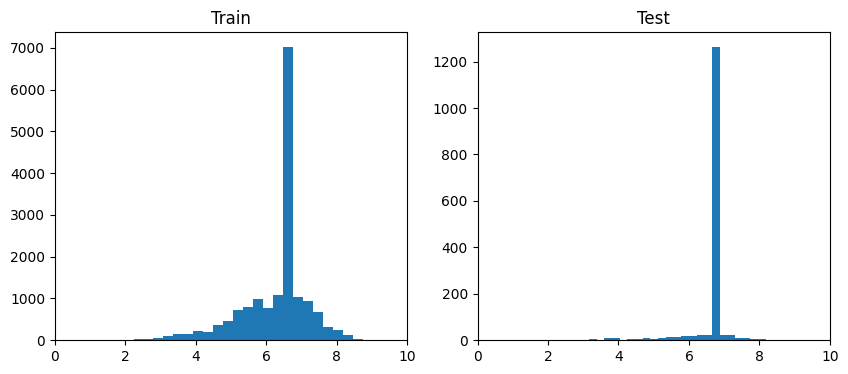

In [74]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["director_score"], bins = 30)
plt.title("Train")
plt.xlim(0,10)
plt.subplot(1,2,2)
plt.hist(test["director_score"], bins = 30)
plt.title("Test")
plt.xlim(0,10)
plt.show;

The histograms of the directors' scores look quite different. This is due to having many directors in the test dataset that were not found on the train dataset, so they are now accounted for as "unknown" and being assigned its average score.

In [75]:
# Seasons
test["seasons"].fillna(0, inplace=True)
i = 0
while i < len(seasons):
    test[seasons[i]] = test["seasons"].apply(fillSeasons)
    i += 1

# Genres
i = 0
while i < len(genres):
    test[genres[i]] = test["genres"].apply(fillGenres)
    i += 1

# Production countries
i = 0
while i < len(producersGrouped):
    test[producersGrouped[i]] = test["production_countries"].apply(fillProducers)
    i += 1

# Type
ohe = OneHotEncoder()
transformed = ohe.fit_transform(test[["type"]])
test[ohe.categories_[0]] = transformed.toarray()

# Streaming
ohe = OneHotEncoder()
transformed = ohe.fit_transform(test[["streaming"]])
test[ohe.categories_[0]] = transformed.toarray()

# Release year
i = 0
while i < len(periods):
    test[periods[i]] = test["release_year"].apply(fillPeriods)
    i += 1

# Age certification
i = 0
while i < len(ageGroups):
    test[ageGroups[i]] = test["age_certification"].apply(fillAges)
    i += 1

# Robust Scaler
test[["runtimeSC", "imdb_votesSC", "director_scoreSC"]] = scaler.transform(test[["runtime", "imdb_votes", "director_score"]])

test.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_votes,streaming,person_id,name,director_score,0seasons,1seasons,2+seasons,comedy,european,crime,drama,...,JP,CA,KR,EUR,OTHER,MOVIE,SHOW,amazon,disney,hbo,hulu,netflix,2008,2017,2020,2023,ageTV,ageOther,ageNone,runtimeSC,imdb_votesSC,director_scoreSC
0,tm54590,Kansas,MOVIE,A drifter becomes both a bank robber and a her...,1988,R,110,"['drama', 'thriller', 'crime', 'romance']",['US'],0.0,1237,amazon,94918,David Stevens,6.750179,1,0,0,0,0,1,1,...,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0.431373,-0.008811,-3.927438e-07
1,tm47969,Vibes,MOVIE,Medium Sylvia Pickel and psychometrist Nick De...,1988,PG,99,"['comedy', 'romance']",['US'],0.0,4828,amazon,26576,Ken Kwapis,6.500000,1,0,0,1,0,0,0,...,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0.215686,0.449751,-2.942665e-01
2,tm124313,Full Moon High,MOVIE,A teenager becomes a werewolf after a family v...,1981,PG,93,"['horror', 'comedy', 'fantasy']",['US'],0.0,1536,amazon,64456,Larry Cohen,5.050000,1,0,0,1,0,0,0,...,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0.098039,0.029370,-1.999789e+00
3,tm120963,Girls Just Want to Have Fun,MOVIE,"Janey is new in town, and soon meets Lynne, wh...",1985,PG,87,"['romance', 'comedy', 'music']",['US'],0.0,12425,amazon,44896,Alan Metter,6.750179,1,0,0,1,0,0,0,...,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,-0.019608,1.419870,-3.927438e-07
4,tm118428,One More Saturday Night,MOVIE,The problems faced by both teenagers and adult...,1986,R,95,['comedy'],['US'],0.0,328,amazon,275525,Dennis Klein,6.750179,1,0,0,1,0,0,0,...,0,0,0,0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0.137255,-0.124888,-3.927438e-07


## 8. Comparison of the features distribution in the train and test datasets

Besides applying the required transformations, we can compare the distribution in the values in the features of both datasets. The more they differ, the less accurate the predictions will be.

Unfortunately, we can see in the following comparisons how many of the features show much shorter ranges and slightly different distributions in the test dataset.

In [89]:
# Type
print("Train")
print(df["type"].value_counts())
print("\nTest")
print(test["type"].value_counts())

Train
MOVIE    12123
SHOW      4422
Name: type, dtype: int64

Test
MOVIE    1209
SHOW      298
Name: type, dtype: int64


(0.0, 60.0)

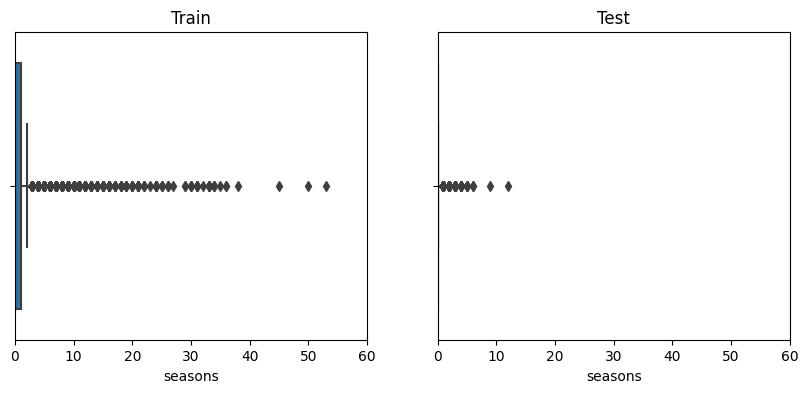

In [90]:
# Seasons
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x=df["seasons"]);
plt.title("Train")
plt.xlim(0,60)
plt.subplot(1,2,2)
sns.boxplot(x=test["seasons"]);
plt.title("Test")
plt.xlim(0,60)

(0.0, 350.0)

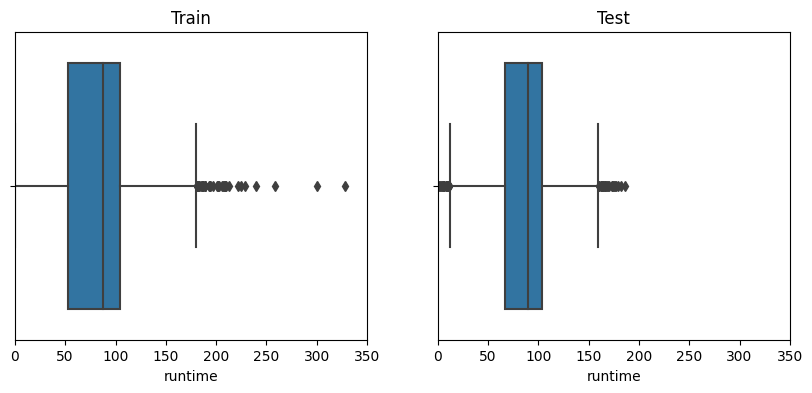

In [91]:
# Runtime
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x=df["runtime"]);
plt.title("Train")
plt.xlim(0,350)
plt.subplot(1,2,2)
sns.boxplot(x=test["runtime"]);
plt.title("Test")
plt.xlim(0,350)

In [92]:
# Streaming
print("Train")
print(df["streaming"].value_counts())
print("\nTest")
print(test["streaming"].value_counts())

Train
amazon     7378
netflix    4282
hbo        2045
hulu       1827
disney     1013
Name: streaming, dtype: int64

Test
amazon     1280
netflix     207
hulu         10
hbo           9
disney        1
Name: streaming, dtype: int64


(1900.0, 2025.0)

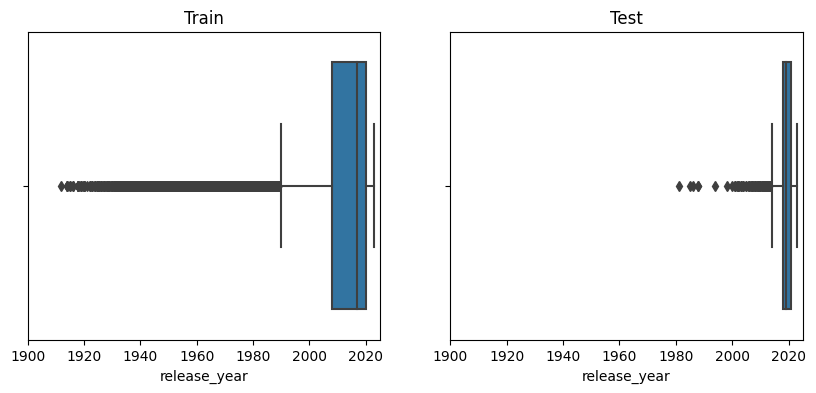

In [93]:
# Release year
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlim(1900, 2025)
plt.title("Train")
sns.boxplot(x=df["release_year"]);
plt.subplot(1,2,2)
sns.boxplot(x=test["release_year"]);
plt.title("Test")
plt.xlim(1900, 2025)

(0.0, 3000000.0)

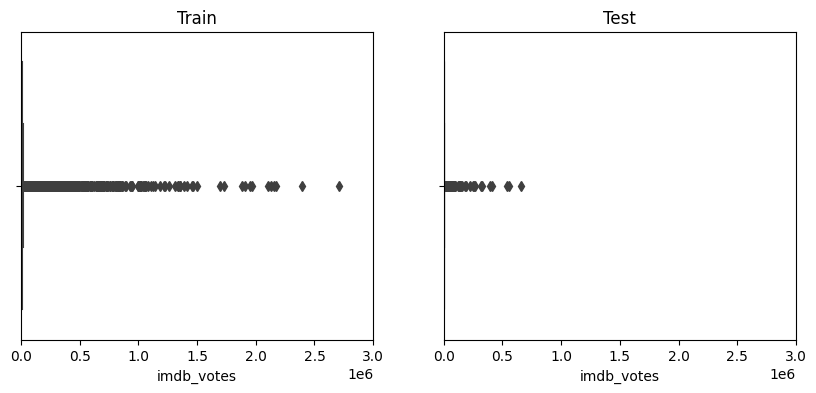

In [94]:
# IMDB votes
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x=df["imdb_votes"]);
plt.title("Train")
plt.xlim(0,3000000)
plt.subplot(1,2,2)
sns.boxplot(x=test["imdb_votes"]);
plt.title("Test")
plt.xlim(0,3000000)

In [96]:
# Age certification groups
print("Train")
print("ageTV: ", (df["ageTV"][df["ageTV"] == 1].sum() / df.shape[0]).round(2))
print("ageOther: ", (df["ageOther"][df["ageOther"] == 1].sum() / df.shape[0]).round(2))
print("ageNone: ", (df["ageNone"][df["ageNone"] == 1].sum() / df.shape[0]).round(2))
print("Test")
print("ageTV: ", (test["ageTV"][test["ageTV"] == 1].sum() / test.shape[0]).round(2))
print("ageOther: ", (test["ageOther"][test["ageOther"] == 1].sum() / test.shape[0]).round(2))
print("ageNone: ", (test["ageNone"][test["ageNone"] == 1].sum() / test.shape[0]).round(2))

Train
ageTV:  0.22
ageOther:  0.3
ageNone:  0.48
Test
ageTV:  0.13
ageOther:  0.21
ageNone:  0.65


## 9. Model predictions
In the last step we generate the predicted imdb_score for the test dataset, then transform it into the target feature, prepare the resulting dataset in the format required for upload and export it as a JSON file.

In [86]:
testX = test[[*types, *periods, "runtimeSC", *genres, *producersGrouped, *seasons, *streaming, *ageGroups, "imdb_votesSC", "director_scoreSC"]]
scorePredict = model_RF.predict(testX)

dfUpload = pd.DataFrame(scorePredict, columns=["score"])
dfUpload["target"] = dfUpload["score"].apply(get_imdb_score_class)
dfUpload.drop("score", inplace=True, axis=1)
dfUpload.head()

,target
0,4
1,5
2,3
3,4
4,3


In [87]:
dfUpload.to_json("predictions.json")